<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/ERA1S7F9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

Same as model 8 ie best model only with training image transform by applyig random rotation

Rotate the image by angle. If the image is torch Tensor, it is expected to have [..., H, W] shape, where ... means an arbitrary number of leading dimensions.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 100412538.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39368116.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32095133.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21672956.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13472793996334076 Batch_id=468 Accuracy=86.67: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]



Test set: Average loss: 0.0587, Accuracy: 9833/10000 (98.33%)

EPOCH: 1


Loss=0.048236966133117676 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:19<00:00, 23.45it/s]



Test set: Average loss: 0.0369, Accuracy: 9888/10000 (98.88%)

EPOCH: 2


Loss=0.04955237731337547 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:19<00:00, 23.56it/s]



Test set: Average loss: 0.0306, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.08465807884931564 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]



Test set: Average loss: 0.0313, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.046807050704956055 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]



Test set: Average loss: 0.0332, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.054589103907346725 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]



Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.06235441192984581 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.01634271629154682 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:19<00:00, 23.88it/s]



Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.02227247692644596 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]



Test set: Average loss: 0.0221, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.07909612357616425 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0212, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.02899465523660183 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]



Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.03232387825846672 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]



Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.012960545718669891 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]



Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.01201231312006712 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Test set: Average loss: 0.0232, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.0343828909099102 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]



Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.06176677718758583 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]



Test set: Average loss: 0.0184, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.0316811129450798 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]



Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.0034044950734823942 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]



Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.017997615039348602 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]



Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.0039482456631958485 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]



Test set: Average loss: 0.0173, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

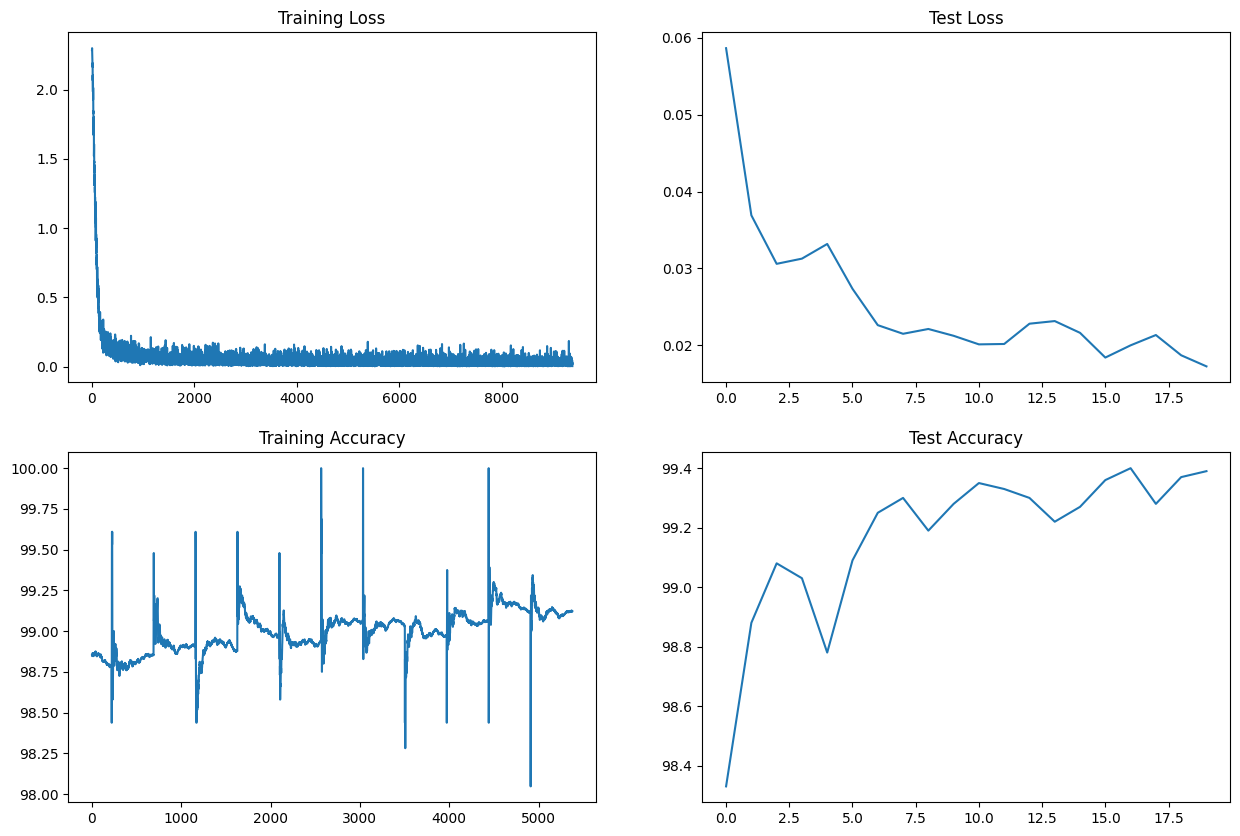

In [10]:
import matplotlib.pyplot as plt
bt = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(bt)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:\
Add rotation, we guess that 5-7 degrees should be sufficient.

Results:\
Parameters: 13.8k\
Best Train Accuracy: 99.15\
Best Test Accuracy: 99.5 (18th Epoch)

Analysis:\
The model is under-fitting now. This is fine, as we know we have made our training data harder.\
The test accuracy is also up, which means our test data had few images that had transformation difference w.r.t. train dataset\
